## <u>SCA6.0 - The Beta-lactamase enzyme family<u/>

This script describes the basic flow of the analytical steps in SCA6.0, using the $\beta $-lactamase enzyme family as an example (PFAM PF13354).  The alignment contains some subfamily structure (clades of related sequences) as evidenced in Section 1. We identify two sectors: a core sector surrounding the active site that is shared across all sequences, and a more peripheral sector containing groups of residues that diverge in particular subfamilies. For this tutorial, the core scripts should be run as follows:

    >> ./annotate_pfMSA.py Inputs/PF13354_full.txt Inputs/PF13354_full.an
    >> ./scaProcessMSA.py Inputs/PF13354_full.an -s 1FQG -c A -f 'Escherichia coli'-t -n
    >> ./scaCore.py Outputs/PF13354_full.db
    >> ./scaSectorID.py Outputs/PF13354_full.db

Note that we supply annotated alignments for all tutorial scripts *(the annotate_pfMSA step is slow, and should only be run once)*.

**O.Rivoire, K.Reynolds and R.Ranganathan**
9/2014


In [1]:
%matplotlib inline
from __future__ import division

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy.cluster.hierarchy as sch
from scipy.stats import scoreatpercentile 
import scaTools as sca
import colorsys
import mpld3
import cPickle as pickle
from optparse import OptionParser

if not os.path.exists('Outputs/'): os.makedirs('Outputs/')  

Read in the results of the above three scripts (scaProcessMSA, scaCore and scaSectorID), stored as three dictionaries in the database PF13354_full.db.  To see what variables are stored in each dictionary, use:

    >>> print dict.keys()

In [2]:
db = pickle.load(open('Outputs/PF13354_full.db','rb'))
Dseq = db['sequence']
Dsca = db['sca']
Dsect = db['sector']

### I. Statistical Structure of the Multiple Sequence Alignment (MSA)

Plot a histogram of all pairwise sequence identities *(left panel)* and a global view of the sequence similarity matrix (defined by $S\equiv \frac{1}{L}XX^\top$) *(right panel)*.  The data show that the alignment is described by a nearly bimodal distribution of sequence identities with peaks near 25% and 45%.  From the matrix at right, it is clear that the alignment is composed of several distinct sequence families.

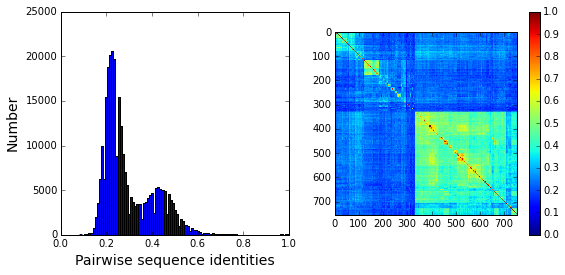

In [3]:
# List all elements above the diagonal (i<j):
listS = [Dsca['simMat'][i,j] for i in range(Dsca['simMat'].shape[0]) \
         for j in range(i+1, Dsca['simMat'].shape[1])]
#Cluster the sequence similarity matrix
Z = sch.linkage(Dsca['simMat'],method = 'complete', metric = 'cityblock')
R = sch.dendrogram(Z,no_plot = True)
ind = map(int, R['ivl'])
#Plotting
plt.rcParams['figure.figsize'] = 9, 4 
plt.subplot(121)
plt.hist(listS, Dseq['Npos']/2)
plt.xlabel('Pairwise sequence identities', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(122)
plt.imshow(Dsca['simMat'][np.ix_(ind,ind)], vmin=0, vmax=1); plt.colorbar();

To examine the role of sequence and position weighting on the structure of the sequence space, we compute correlation matrices between all pairs of sequences, either with or without sequence and position weights and project the corresponding sequence space (by eigenvalue decomposition) down to a small set of top modes that contain the statistically dominant relationships between sequences.  Since eigenvalue decomposition does not necessarily provide the best representation of sequence groups (for reasons described in "xx"), we also apply independent components analysis (or ICA) to the top few eigenmodes; this manipulation provides a representation in which the top groupings of sequences in the alignment (if such exists) should separate along the so-called independent components (or ICs). Below we plot the following eigenmodes *(top row)* and independent components *(bottom row)*:

$\bullet$ $U^{(0)}$ and $U'^{(0)}$, the top eigenmodes and ICs without any weights;

$\bullet$ $U^{(1)}$ and $U'^{(1)}$ the top eigenmodes and ICs with sequences weights;

$\bullet$ $U^{(2)}$ and $U'^{(2)}$ the top eigenmodes and ICs with both sequences and positional weights.

The sequences are colored by weight, with red indicating the most strongly downweighted sequences. In contrast to the g-protein example, we see that application of the sequence and position weights makes the sequence space apparently more uniform (removes some of the family or clade-like structure).

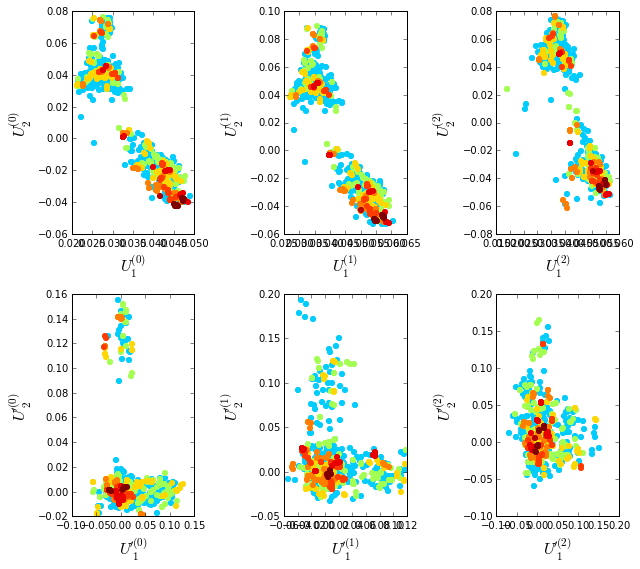

In [4]:
Useq = Dsca['Useq']
Uica = Dsca['Uica']
plt.rcParams['figure.figsize'] = 9, 8 
ica = ["","","","'","'","'"]
for k,U in enumerate(Useq+Uica):
    plt.subplot(2,3,k+1)
    sca.figWeights(U[:,0], U[:,1], Dseq['seqw'][0])
    plt.xlabel(r'${U%s}^{(%i)}_1$'%(ica[k],k%3), fontsize=16)
    plt.ylabel(r'${U%s}^{(%i)}_2$'%(ica[k],k%3), fontsize=16)
plt.tight_layout()

To examine the relationship between divergence in *sequence similarity* and *phylogeny* in the sequence-weighted alignment, we plot the top independent components of the sequence correlation matrix (after sequence weighting), colored by phylogenetic group. We start by constructing a dictionary of phylogenetic annotations and checking the representation of sequences in the top taxonomic levels.  The annotations are parsed from the sequence headers.

In [5]:
#construct a dictionary of phylogenetic groups
annot = dict()
for i, h in enumerate(Dseq['hd']):
    hs = h.split('|')
    annot[hs[0]] = sca.Annot(hs[1], hs[2], hs[3].replace('.',''))
    
# Most frequent taxonomic groups:
atleast = 10
for level in range(4):
    descr_list = [a.taxo.split(',')[level] for a in annot.values() \
                  if len(a.taxo.split(',')) > level]
    descr_dict = {k:descr_list.count(k) for k in descr_list \
                  if descr_list.count(k)>=atleast}
    print '\n Level %i:' % level
    print descr_dict    


 Level 0:
{'Bacteria': 745}

 Level 1:
{'environmental samples': 18, 'Firmicutes': 100, 'Bacteroidetes': 49, 'Actinobacteria': 133, 'Cyanobacteria': 62, 'Proteobacteria': 353, 'Acidobacteria': 10}

 Level 2:
{'Lactobacillales': 11, 'Betaproteobacteria': 66, 'Bacteroidia': 25, 'Flavobacteriia': 11, 'Gammaproteobacteria': 176, 'Chroococcales': 34, 'Oscillatoriales': 11, 'Actinobacteridae': 128, 'Bacillales': 47, 'Clostridia': 33, 'Alphaproteobacteria': 103, 'Nostocales': 11}

 Level 3:
{'Burkholderiales': 64, 'Flavobacteriales': 11, 'Sphingomonadales': 30, 'Rhizobiales': 39, 'Vibrionales': 24, 'Rhodospirillales': 15, 'Clostridiales': 28, 'Actinomycetales': 128, 'Thiotrichales': 13, 'Enterobacteriales': 79, 'Xanthomonadales': 17, 'Nostocaceae': 11, 'Bacteroidales': 25, 'Synechococcus': 14, 'Caulobacterales': 10, 'Bacillaceae': 29, 'Pseudomonadales': 25}


Based on this, we select taxonomic groups and colors for representation.  Here, we just start by choosing the broadly well-represented groups. To see a complete color-coding legend, use: 
    
    >>> sca.figColors()

In [6]:
phylo = list();
fam_names = ['Firmicutes', 'Actinobacteria', 'Bacteroidetes', \
             'Cyanobacteria', 'Proteobacteria']
col = (0, 0.18, 0.38, 0.5, 0.6)
#Firmicutes = red, Actinobacteria = yellow, Bacteroidetes = cyan, 
#Cyanobacteria = green, Proteobacteria = blue
for i,k in enumerate(fam_names):
    sf = sca.Unit()
    sf.name = fam_names[i].lower()
    sf.col = col[i]
    sf.items = [j for j,q in enumerate(Dseq['hd'])  if sf.name in q.lower()]
    phylo.append(sf)

Plot the top six independent components of the sequence correlation matrix (with sequence weights); color-coded by phylogenetic annotation. The sequences clearly seperate into groups related by phylogeny; the Proteobacteria *(blue)* seperate out on $U_1$, the Firmicutes *(red)* seperate out on $U_2$, the Cyanobacteria *(green)* seperate out on $U_3$, and the Bacteroidetes *(cyan)* seperate out on $U_5$. 

[[0, 1], [2, 3], [4, 5]]


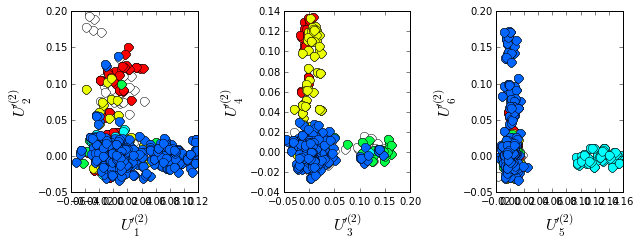

In [7]:
plt.rcParams['figure.figsize'] = 9, 3.5
U = Dsca['Uica'][1]
pairs = [[2*i,2*i+1] for i in range(3)]
print pairs
for k,[k1,k2] in enumerate(pairs):
    plt.subplot(1,3,k+1)
    sca.figUnits(U[:,k1], U[:,k2], phylo)
    #sca.figUnits(U[:,k1], U[:,k2], subfam)
    plt.xlabel(r"${U'}^{(2)}_{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"${U'}^{(2)}_{%i}$"%(k2+1), fontsize=16)
plt.tight_layout()

### II. <u>SCA conservation and coevolution<u/>

Plot the eigenspectrum of the SCA positional coevolution matrix ($\tilde{C_{ij}}$) *(black bars)* and 10 trials of matrix randomization for comparison *(red line)*. This graph is used to choose the number of significant eigenmodes.

Number of eigenmodes to keep is 6


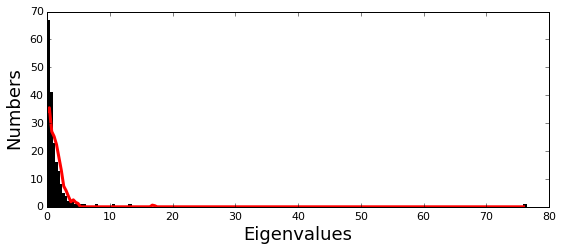

In [8]:
plt.rcParams['figure.figsize'] = 9, 3.5 
hist0, bins = np.histogram(Dsca['Lrand'].flatten(), bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
hist1, bins = np.histogram(Dsect['Lsca'], bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
plt.bar(bins[:-1], hist1, np.diff(bins),color='k')
plt.plot(bins[:-1], hist0/Dsca['Ntrials'], 'r', linewidth=3)
plt.tick_params(labelsize=11)
plt.xlabel('Eigenvalues', fontsize=18); plt.ylabel('Numbers', fontsize=18);
print 'Number of eigenmodes to keep is %i' %(Dsect['kpos'])

To define the positions with significant contributions each of the independent components (ICs), we make a empirical fit for each IC to the t-distribution and select positions with greater than a specified cutoff on the CDF.  We choose $p=0.95$ as our cutoff.  Note that since some positions might contribute significantly to more than one IC (and indication of non-independence of ICs), we  apply a simple algorithm to assign such positions to one IC.  Specifically, we assign positions to the IC with which it has the greatest degree of co-evolution.<br/>

The data indicate generally good fits for the top six ICs, and we return the positions contributing to each IC in a format suitable for cut and paste into PyMol.  

IC 1 is composed of 21 positions:
65+66+71+117+123+125+136+157+164+169+170+178+179+180+210+229+233+247+250+251+255

IC 2 is composed of 14 positions:
70+73+91+130+131+132+134+143+156+182+234+235+236+245

IC 3 is composed of 18 positions:
72+102+105+106+107+126+144+145+166+183+185+199+207+215+216+226+238+244

IC 4 is composed of 11 positions:
85+87+97+129+200+203+211+221+225+231+240

IC 5 is composed of 15 positions:
68+69+119+122+139+149+151+153+161+162+163+181+186+193+220

IC 6 is composed of 2 positions:
241+256



/Users/kreynolds/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


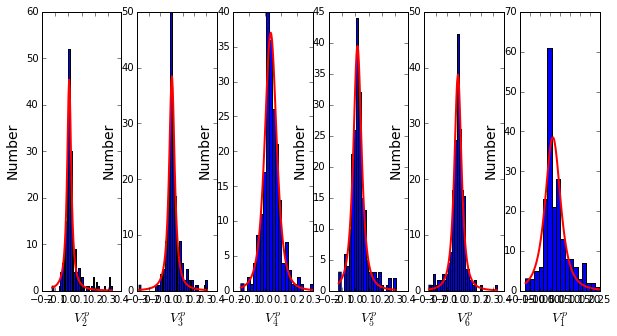

In [9]:
plt.rcParams['figure.figsize'] = 10,5 

Vpica = Dsect['Vpica']
for k in range(Dsect['kpos']):
    iqr = scoreatpercentile(Vpica[:,k],75) - scoreatpercentile(Vpica[:,k],25)
    binwidth=2*iqr*(len(Vpica)**(-0.33))
    nbins=round((max(Vpica[:,k])-min(Vpica[:,k]))/binwidth)
    plt.subplot(1,Dsect['kpos'],k)
    h_params = plt.hist(Vpica[:,k], nbins)
    x_dist = np.linspace(min(h_params[1]), max(h_params[1]), num=100)
    plt.plot(x_dist,Dsect['scaled_pd'][k],'r',linewidth = 2)    
    plt.xlabel(r'$V^p_{%i}$'%(k+1), fontsize=14)
    plt.ylabel('Number', fontsize=14)
    
for n,ipos in enumerate(Dsect['ics']):
    sort_ipos = sorted(ipos.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('IC %i is composed of %i positions:' % (n+1,len(ats_ipos)))
    print(ic_pymol + "\n")

To define protein sectors, we examine the structure of the SCA positional correlation matrix with positions contributing to the top  independent components (ICs) ordered by weight *(left panel)*.  This provides a basis to determine/interpret which ICs are truly statistically independent (defining an independent sector) and which represent hierarchical breakdowns of one sector. 

IC 2 appears more distinct and is considered an independent sector *(sector 1)*. ICs 1,3,5,and 6 are strongly co-evolving, and should be combined into one sector. IC 4 also appears to be related to [1,3,5,6] and the combination of 1,3,4,5,6 makes up sector two. The sectors (2 in total) are defined accordingly, and in the *right panel*, these independent components have been re-ordered accordingly to visualize this decomposition.

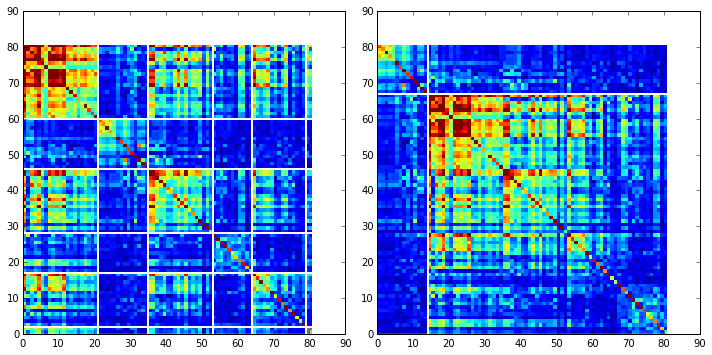

In [10]:
#plot the SCA positional correlation matrix, ordered by contribution to the top ICs
plt.rcParams['figure.figsize'] = 10, 10 
plt.subplot(121)
plt.imshow(Dsca['Csca'][np.ix_(Dsect['sortedpos'], Dsect['sortedpos'])], \
           vmin=0, vmax=2,interpolation='none',aspect='equal',\
           extent=[0,sum(Dsect['icsize']),0,sum(Dsect['icsize'])])
line_index=0
for i in range(Dsect['kpos']):
    plt.plot([line_index+Dsect['icsize'][i],line_index+Dsect['icsize'][i]],\
             [0,sum(Dsect['icsize'])],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[sum(Dsect['icsize'])-line_index,\
                        sum(Dsect['icsize'])-line_index],'w', linewidth = 2)
    line_index += Dsect['icsize'][i] 

#define the new sector groupings - 2 total
sec_groups = ([1],[0,2,4,5,3])
sectors = list()
for n,k in enumerate(sec_groups):
    s = sca.Unit()
    all_items = list()
    for i in k: all_items = all_items+Dsect['ics'][i].items
    s.items = all_items
    s.col = (1/len(sec_groups))*n
    sectors.append(s)

#plot the re-ordered matrix
plt.subplot(122)
line_index=0
sortpos = list()
for s in sectors:
    sortpos.extend(s.items)
plt.imshow(Dsca['Csca'][np.ix_(sortpos, sortpos)], vmin=0, vmax=2,\
           interpolation='none',aspect='equal',\
           extent=[0,len(sortpos),0,len(sortpos)])
for s in sectors:
    plt.plot([line_index+len(s.items),line_index+len(s.items)],\
             [0,len(sortpos)],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[len(sortpos)-line_index, \
                                       len(sortpos)-line_index],'w', linewidth = 2)
    line_index += len(s.items)
plt.tight_layout()

Print the sector positions, in a format suitable for pyMol, and create a pyMol session with the sectors (and decomposition into independent components) as seperate objects. Structurally, sectors 1+3 form physically contiguous units, and 2 is less so... this is consistent with the idea that sector 2/IC4 might be associated with sector 1/ICs1+3+5+6

In [11]:
for i,k in enumerate(sectors):
    sort_ipos = sorted(k.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('Sector %i is composed of %i positions:' % (i+1,len(ats_ipos)))
    print(ic_pymol + "\n")
sca.writePymol('1FQG', sectors, Dsect['ics'], Dseq['ats'], \
               'Outputs/PF13354.pml','A', '../Inputs/', 0)  

Sector 1 is composed of 14 positions:
70+73+91+130+131+132+134+143+156+182+234+235+236+245

Sector 2 is composed of 67 positions:
65+66+68+69+71+72+85+87+97+102+105+106+107+117+119+122+123+125+126+129+136+139+144+145+149+151+153+157+161+162+163+164+166+169+170+178+179+180+181+183+185+186+193+199+200+203+207+210+211+215+216+220+221+225+226+229+231+233+238+240+241+244+247+250+251+255+256



### III. The phylogenetic basis of the sector hierarchy

How does the clear phylogenetic heterogeneity in the MSA influence the sector definitions?  To address this, we take advantage of mathematical methods for mapping between the space of positional and sequence correlations, as described in *Rivoire et al*.  Using this mapping, we plot the top $k_{pos}$ ICs as 2-D scatter plots with the corresponding sequence space divergence.  The colors for the sequence space are according to the phylogenetic classifications we chose above. 

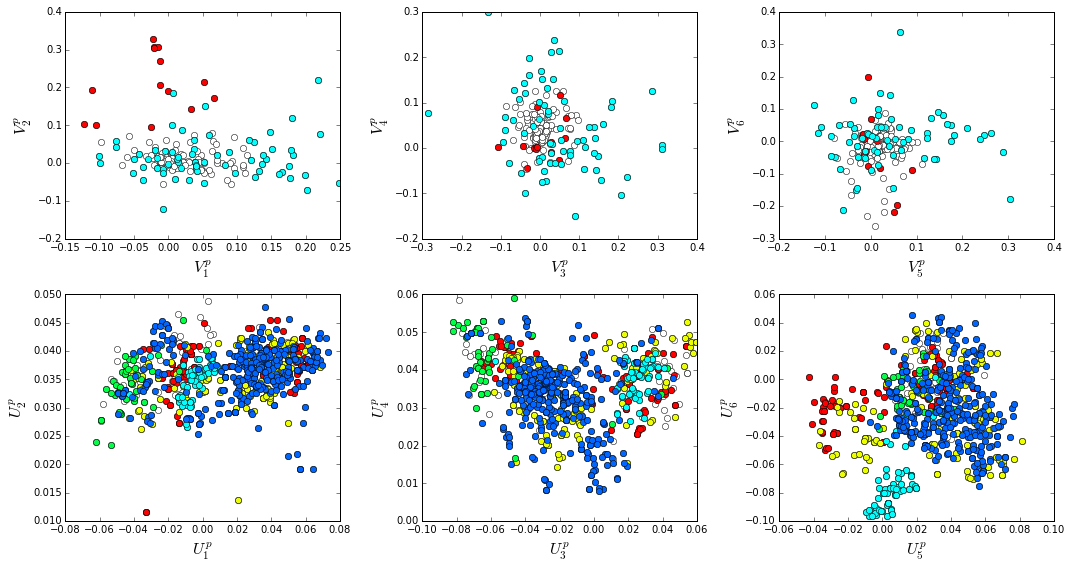

In [12]:
plt.rcParams['figure.figsize'] = 15,8
pairs= [[0,1],[2,3],[4,5]]
for n,[k1,k2] in enumerate(pairs):
    plt.subplot(2,3,n+1)
    sca.figUnits(Dsect['Vpica'][:,k1], Dsect['Vpica'][:,k2], sectors, dotsize = 6)
    plt.xlabel(r'$V^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$V^p_{%i}$' % (k2+1), fontsize=16)
    plt.subplot(2,3,n+4)
    sca.figUnits(Dsect['Upica'][:,k1], Dsect['Upica'][:,k2], phylo, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
plt.tight_layout()

The interpretation for the two sectors:

**Sector 1**  is defined along ($V_2^p$). The sequences along the corresponding component ($U_2^p$) are homogeneously distributed with respect to phylogeny, consistent with the notion that this sector is a property of the entire alignment. Notably, this sector forms the catalytic core of the Beta-lactamase.

**Sector 2**  is composed of ICs 1,3,4 and 5 - and  each of these is associated with some phylogenetic divergence.  $V_1^p$ splits the cyanobacteria *(green)* from the proteobacteria *(blue)*, $V_3^p$ seperates the proteobacteria *(blue)* from other sequence families, $V_5^p$ seperates out a subset of the firmicutes *(red)*, and $V_6^p$ is associated with a divergence in the bacteriodetes *(cyan)*. Sector 2 forms a physically contiguous unit that resembles a shell around the active site. The decomposition described above suggests that some functional divergence in beta-lactamse dynamics or regulatory mechanism across phylogenetic lines may underlie the breakdown of this sector.

For clarity, we also plot the same data as a stacked bar chart below.

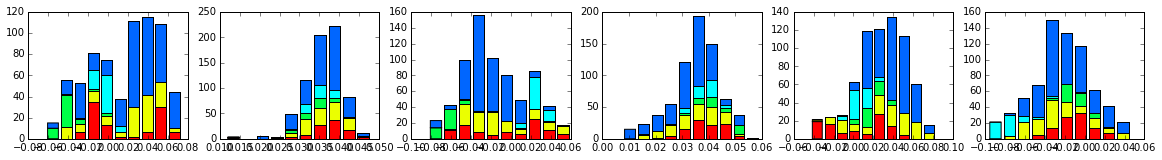

In [13]:
plt.rcParams['figure.figsize'] = 20, 5 
    
col = list()
for k in phylo:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in phylo:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.subplot(2,Dsect['kpos'],k+1)
    plt.hist(forhist, histtype='barstacked',color=col)

This concludes the script.